In [1]:
# defining globals
job_info_file_partial_path = 'plugin=job_table/metric=job_info_marconi100/a_0_filter123_singlenode.csv'
total_power_file_partial_path = 'plugin=ipmi_pub/metric=total_power/a_0_filter123_singlenode.csv'
column_dtypes = {'resv_name': object}

### Checking that start time and end time difference results in runtime for all rows in all datasets

In [ ]:
import os
import pandas as pd

# Specify the root directory where your HPC job log dataset is located
root_directory = '../data'

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)

    if os.path.isdir(month_path):
        # Construct the file path based on the pattern
        file_path = os.path.join(month_path, job_info_file_partial_path)

        if os.path.exists(file_path):
            
            df = pd.read_csv(file_path, dtype=column_dtypes)
                        
            # Filter rows where start_time + runtime is not equal to end_time
            invalid_rows = df[~((pd.to_datetime(df['start_time']) + pd.to_timedelta(df['run_time'], unit='s')) == pd.to_datetime(df['end_time']))]

            # Print the invalid rows
            if not invalid_rows.empty:
                print(f'Invalid rows in {month_folder}:')
                print(invalid_rows)
                print('\n---\n')
            else:
                print("All rows have consistent start time, end time and runtime values.")

### Merging IPMI dataset with job_table dataset by job ID for month 22-08

In [9]:
chunk_size = 10000  # Chunk to merge dataframes without compromising memory usage

month_path = os.path.join(root_directory, 'year_month=22-08')
job_info_file_path = os.path.join(month_path, job_info_file_partial_path)
total_power_file_path = os.path.join(month_path, total_power_file_partial_path)

job_info_chunks = pd.read_csv(job_info_file_path, dtype=column_dtypes, chunksize=chunk_size)
total_power_chunks = pd.read_csv(total_power_file_path, chunksize=chunk_size)

merged_df = pd.DataFrame()

for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
    merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
    merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)


### Visualizing the time series of power consumption for the longest running job in Marconi during 22-08

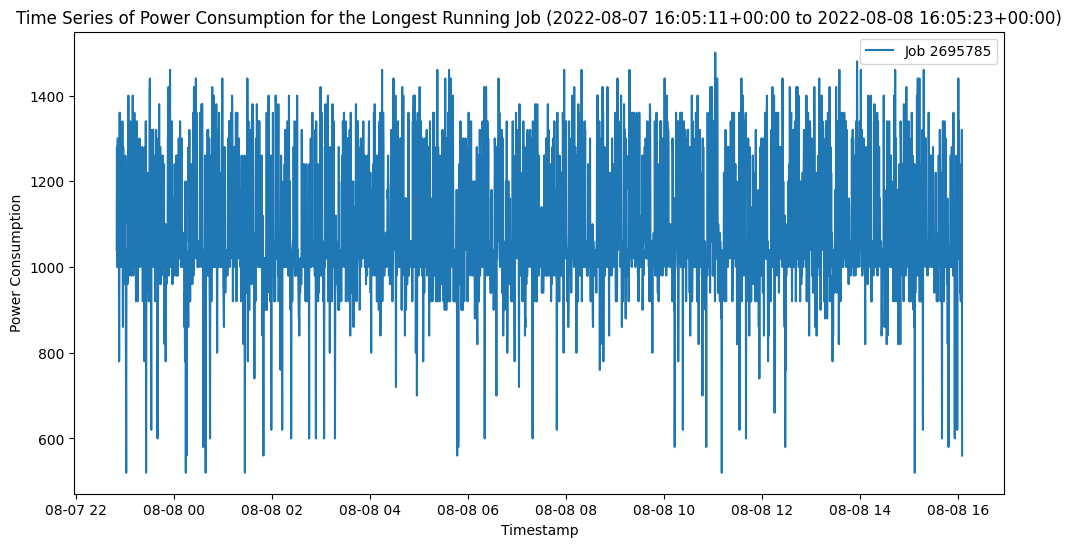

In [11]:
import matplotlib.pyplot as plt

time_series_column = 'timestamp'
run_time_column = 'run_time'
power_consumption_column = 'value'

# Find the row corresponding to the longest running job
longest_running_job_row = merged_df.loc[merged_df[run_time_column].idxmax()]

# Extract the information
start_time = longest_running_job_row['start_time']
end_time = longest_running_job_row['end_time']
longest_running_job_power = merged_df[merged_df['job_id'] == longest_running_job_row['job_id']][[time_series_column, power_consumption_column]]

# Plot the time series of power consumption for the longest running job
plt.figure(figsize=(12, 6))
plt.plot(longest_running_job_power[time_series_column], longest_running_job_power[power_consumption_column], label=f'Job {longest_running_job_row["job_id"]}')
plt.title(f'Time Series of Power Consumption for the Longest Running Job ({start_time} to {end_time})')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()
